In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
import random

wandb initialization

Data

In [154]:
df = pd.read_csv("data/filtered_ds.csv")

In [155]:
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [156]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [157]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0
    
    data = data.sort_values(by=["start_time_min"])
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [194]:
data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

In [159]:
model_data = data[["patient_id"] + ["domain %d score" % i for i in range(1, 15)]]

In [160]:
## pick a random patient for case study
pid = random.choice(pd.unique(model_data["patient_id"]))
# pid = 346256
## save the patient's data
case_study_data = copy.deepcopy(model_data[model_data['patient_id'] == pid])
## remove the patient's data from the dataset
model_data = model_data.drop(model_data[model_data['patient_id'] == pid].index)

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

In [161]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [162]:
model_data = filter_nonzero_rows(model_data, 0)

In [163]:
model_data = model_data[["domain %d score" % i for i in range(1, 15)]]

In [164]:
model_data = model_data.to_numpy()

In [165]:
def generate_random_array(rows, cols, ratio_of_zeros):
    total_elements = rows * cols
    num_zeros = int(total_elements * ratio_of_zeros)
        
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign zeros to the array
    indices = np.random.choice(total_elements, num_zeros, replace=False)
    array.ravel()[indices] = 0
    
    return array

In [166]:
def generate_mask(data):
    rows, cols = data.shape
    assert(cols == 14)
    domains_masked = generate_random_array(rows, cols, 0.8)
    return data * domains_masked

In [167]:
ground_truth = copy.deepcopy(model_data)
model_data = generate_mask(model_data)

In [168]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [169]:
model_data = create_missing_indicator(model_data)
ground_truth = create_missing_indicator(ground_truth)

In [170]:
np.count_nonzero(model_data == 1)

1591455

Model

In [171]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 25
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains * 2)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

masking

In [172]:
def missing(arr):
    assert(len(arr) == 2)
    # if two values are the same (the only three possible values pairs are (0, 0), (1, 1), and (0.5, 0.5))
    return arr[0] == arr[1] and (arr[0] == 0 or arr[0] == 1)

Training

In [173]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w * 2)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            # # handle missing value
            missing_exists = False
            missing_domains = []
            for domain in range(w):
                if missing(session[domain*2:domain*2+2]):
                    missing_exists = True
                    missing_domains.append(domain)
                
            # assert missing_exists == False, "shouldn't have missing values"
            target = copy.deepcopy(y_train[i].reshape(-1, w * 2))
            if missing_exists:
                recon = reconstructed.detach().numpy()
                for d in missing_domains:
                    target[0, d*2:d*2+2] = recon[0, d*2:d*2+2]
            target = torch.from_numpy(target).float()


            # Calculating the loss function
            loss = loss_function(reconstructed, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w * 2)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.from_numpy(y_val[k].reshape(-1, w * 2)).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    return losses, val_losses, outputs, model

In [174]:
num_runs = 5

In [175]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = AE()
    epochs = 5
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(model_data, ground_truth, test_size=0.50)
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

In [176]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

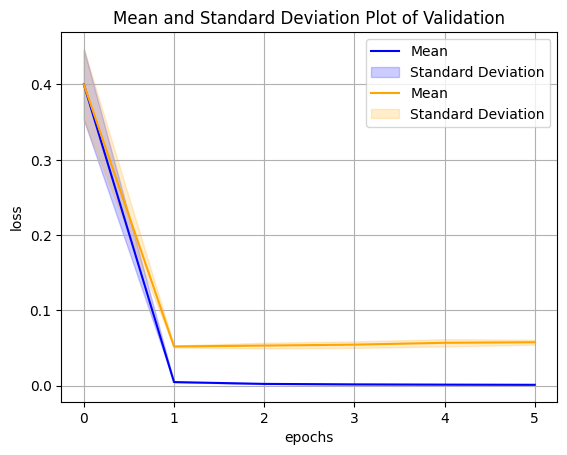

In [177]:
# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

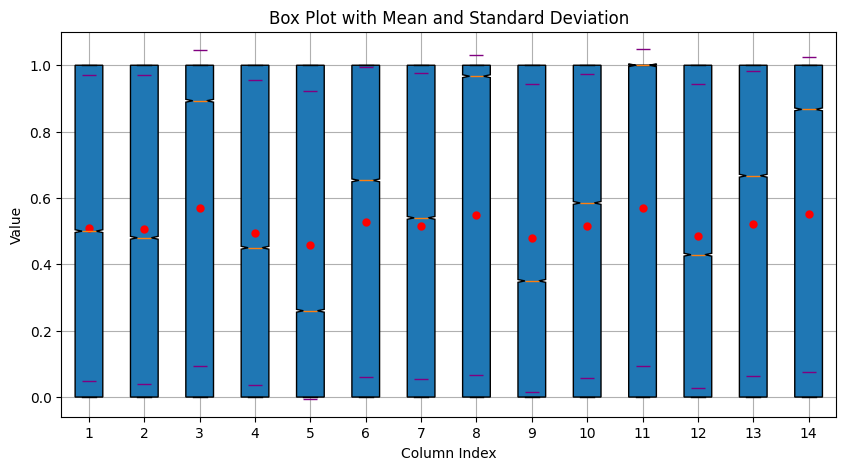

In [178]:
def enhanced_box_plot(data_array):
    """
    Creates a box plot for each column in the given NumPy array and overlays mean and standard deviation.
    
    Parameters:
    - data_array (numpy.ndarray): A 2D NumPy array where each column represents a series of data points.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create the boxplot
    bp = ax.boxplot(data_array, patch_artist=True, notch=True, meanline=True)
    
    # Calculate means and standard deviations
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    n_cols = data_array.shape[1]

    # Add mean and standard deviation lines
    for i in range(n_cols):
        # Mean line
        plt.plot([i+1], [means[i]], color='red', marker='o', markersize=5)
        # Standard deviation lines
        plt.plot([i+1, i+1], [means[i] - stds[i], means[i] + stds[i]], color='purple', marker='_', markersize=10, linestyle='None')

    # Customizing the plot
    plt.title('Box Plot with Mean and Standard Deviation')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

enhanced_box_plot(model_data[:, 0::2])

In [179]:
zero_test = np.zeros((5000, 14))

In [180]:
temp = np.zeros((5000, 14*2))
for i in range(5000):
    for d in range(14):
        p = zero_test[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            temp[i, d*2] = missing_ind
            temp[i, d*2+1] = missing_ind
        else:
            temp[i, d*2] = p # score
            temp[i, d*2+1] = 1-p # 1-score

zero_test = copy.deepcopy(temp)

In [181]:
model.eval()
total = np.zeros((1, 28))
with torch.no_grad():
    for row in zero_test:
        temp = row.reshape(-1, 14 * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        output = model(temp).detach().numpy()[0]
        total = output + total

total = total/5000
total

array([[0.52558232, 0.47463628, 0.49264925, 0.5075414 , 0.66909101,
        0.33091377, 0.52634004, 0.47380083, 0.37305826, 0.62697596,
        0.50943814, 0.49071057, 0.47673161, 0.52345179, 0.60071735,
        0.3992359 , 0.45060954, 0.54934935, 0.49494163, 0.50510667,
        0.60806674, 0.39200487, 0.49239369, 0.50767978, 0.6418241 ,
        0.35816876, 0.51785326, 0.48240567]])

### See how this changes the score trajectory

In [182]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_rename_dict = {}
for i in range(len(column_names)):
    column_rename_dict[column_names[i]] = i + 1

In [183]:
def get_score(data : pd.DataFrame):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data = data.sort_values(by="start_time_min").reset_index(drop=True)
    column_names = ["domain %d score" % i for i in range(1, 15)]

    for idx, row in data.iterrows():
        domain_ids, _ = process_row(row)
        for j in range(len(domain_ids)):
            col = column_names[int(domain_ids[j] - 1)]
            updated_domain_pct[col] = row[col] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # return scores list
    return scores

In [184]:
patient_data_scores = case_study_data[column_names].to_numpy()
patient_data_scores.shape

(191, 14)

In [185]:
l, w = patient_data_scores.shape

In [186]:
patient_data_scores = create_missing_indicator(patient_data_scores)

In [187]:
input_tensor = torch.from_numpy(patient_data_scores).float()

model.eval()
with torch.no_grad():
    predictions = model(input_tensor).numpy()

In [188]:
predictions = predictions[:, ::2]

In [189]:
def remove_zero_columns(df1, df2):
    """
    Removes columns from the second DataFrame that correspond to all-zero columns in the first DataFrame.

    Parameters:
    - df1 (pd.DataFrame): A DataFrame where some columns might have all elements as zero.
    - df2 (pd.DataFrame): A DataFrame from which the corresponding all-zero columns in df1 will be removed.

    Returns:
    - pd.DataFrame: A modified DataFrame with the all-zero columns removed from df2.
    """
    # Check that the number of columns in df1 and df2 match
    if df1.shape[1] != df2.shape[1]:
        raise ValueError("Both DataFrames must have the same number of columns.")

    # Find columns in the first DataFrame that have all zeros
    zero_columns = df1.columns[(df1 == 0).all()]

    # Remove the corresponding columns from the second DataFrame
    filtered_df = df2.drop(columns=zero_columns)

    return filtered_df

In [190]:
# Calculate the difference
difference = predictions - case_study_data.iloc[:, -14:].to_numpy()
difference = pd.DataFrame(data=difference, columns=column_names)
difference = remove_zero_columns(case_study_data.iloc[:, -14:], difference)

In [191]:
predictions = pd.DataFrame(data=predictions, columns=column_names)

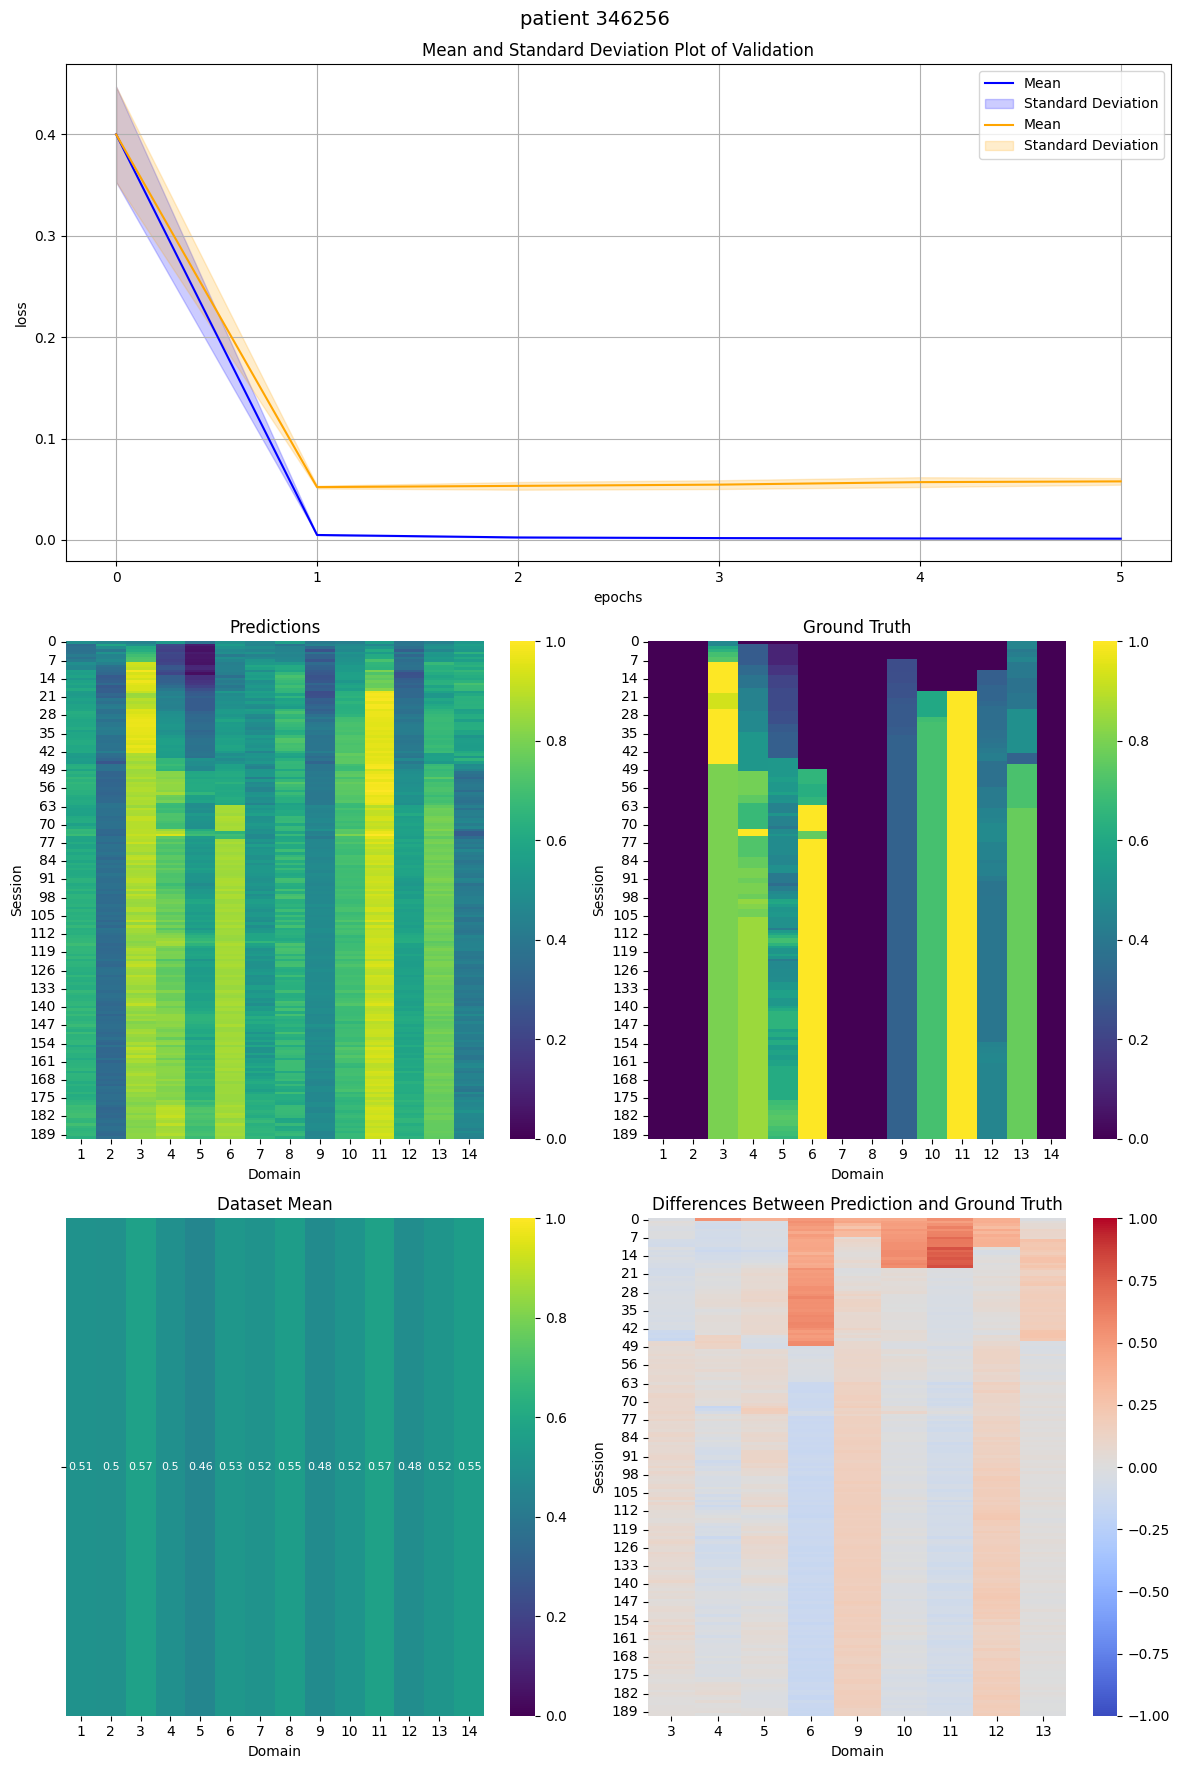

In [192]:
# Create a figure for subplots
fig = plt.figure(figsize=(12, 18))  # Increase figure size if necessary

# set vmin and vmax
vmin = 0
vmax = 1

with torch.no_grad():
    plt.subplot(3, 1, 1)
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# Plotting the first matrix heatmap
plt.subplot(3, 2, 3)
sns.heatmap(predictions.rename(columns=column_rename_dict), cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Predictions")
plt.xlabel("Domain")
plt.ylabel("Session")

# Plotting the second matrix heatmap
plt.subplot(3, 2, 4)
sns.heatmap(case_study_data.iloc[:, -14:].rename(columns=column_rename_dict), cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Ground Truth")
plt.xlabel("Domain")
plt.ylabel("Session")

# Plotting the third matrix heatmap
ax = plt.subplot(3, 2, 5)
mean_data = np.mean(x_train, axis=0)[::2].reshape(1, -1)
sns.heatmap(mean_data, cmap="viridis", cbar=True, annot=True, annot_kws={"size": 8}, vmin=vmin, vmax=vmax)
plt.title("Dataset Mean")
plt.xlabel("Domain")
ax.set_xticklabels(range(1, 15))
ax.set_yticklabels("")

# Heatmap of difference between two matrices
# Plotting the heatmap
plt.subplot(3, 2, 6)
sns.heatmap(difference.rename(columns=column_rename_dict), cmap="coolwarm", cbar=True, center=0, vmin=-1, vmax=1)
plt.title("Differences Between Prediction and Ground Truth")
plt.xlabel("Domain")
plt.ylabel("Session")

# Adjust the spacing between the plots and margins of the figure
fig.suptitle("patient %d" % pid, size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# Show the plot
plt.show()